In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# Load the CitrusLeaves dataset
dataset, info = tfds.load('svhn_cropped', with_info=True, as_supervised=True)
# Extract only the images from the dataset
image_dataset = dataset['train'].map(lambda image, label: image)

# Take a batch of images to verify
for image_batch in image_dataset.take(1):
    print(image_batch.shape)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/73257 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.VTEMPZ_3.1.0/svhn_cropped-train.tfrecord*...:   0%…

Generating test examples...:   0%|          | 0/26032 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.VTEMPZ_3.1.0/svhn_cropped-test.tfrecord*...:   0%|…

Generating extra examples...:   0%|          | 0/531131 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.VTEMPZ_3.1.0/svhn_cropped-extra.tfrecord*...:   0%…

Dataset svhn_cropped downloaded and prepared to /root/tensorflow_datasets/svhn_cropped/3.1.0. Subsequent calls will reuse this data.
(32, 32, 3)


In [2]:
image_array = np.array([image.numpy() for image in image_dataset])
print(image_array.shape)

(73257, 32, 32, 3)


In [3]:
latent_dim = 128

encoder_inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z = layers.Dense(latent_dim, name="z")(x)
encoder = keras.Model(encoder_inputs, z, name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 16, 16, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │          65,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ z (Dense)                            │ (None, 128)                 │           2,176 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,120 (340.31 KB)

 Trainable params: 87,120 (340.31 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs) #adjust this to 8
x = layers.Reshape((8, 8, 64))(x) #adjust this to 8
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │         528,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 584,643 (2.23 MB)

 Trainable params: 584,643 (2.23 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
class AE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        #self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property

    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            #self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(data, reconstruction),
                    axis=(1, 2),
                )
            )
            total_loss = reconstruction_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        #self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            #"kl_loss": self.kl_loss_tracker.result(),

        }

    def call(self, inputs):
        z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed


In [6]:
image_array = np.array([image.numpy() for image in image_dataset]).astype("float32") / 255

In [7]:
keras.backend.clear_session()
tf.random.set_seed(1234)

ae = AE(encoder, decoder)
keras.backend.clear_session()
tf.random.set_seed(1234)
ae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))
history = ae.fit(image_array, epochs=400, batch_size=1020)

Epoch 1/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - loss: 42.7054 - reconstruction_loss: 42.7054
Epoch 2/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 35.9057 - reconstruction_loss: 35.9057
Epoch 3/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 13.9878 - reconstruction_loss: 13.9878
Epoch 4/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 11.7789 - reconstruction_loss: 11.7789
Epoch 5/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 10.6634 - reconstruction_loss: 10.6634
Epoch 6/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 9.7600 - reconstruction_loss: 9.7600
Epoch 7/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 9.1224 - reconstruction_loss: 9.1224
Epoch 8/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 8.6121 - reconstruction_loss: 8.6121
Epoch 9/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 8.2005 - reconstruction_loss: 8.2005
Epoch 10/400
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 7.9035 - reconstruction_loss: 7.9035
Epoch 11/400
72/

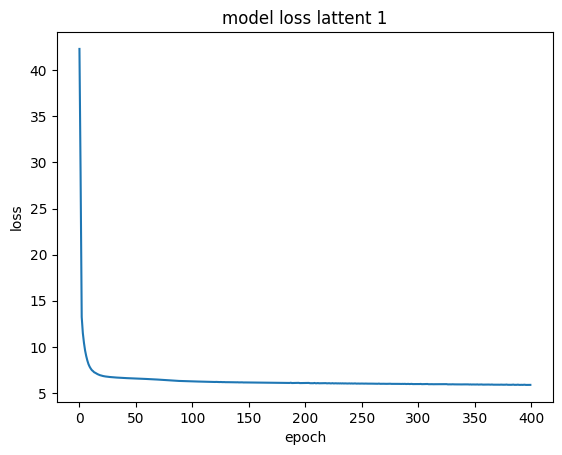

In [8]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['reconstruction_loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss lattent 1')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
ae.build(input_shape=(None, 32, 32, 3)) # Build the model with the input shape

# Existing code to save the model weights
ae.save_weights('AE_svhn_latent.weights.h5')

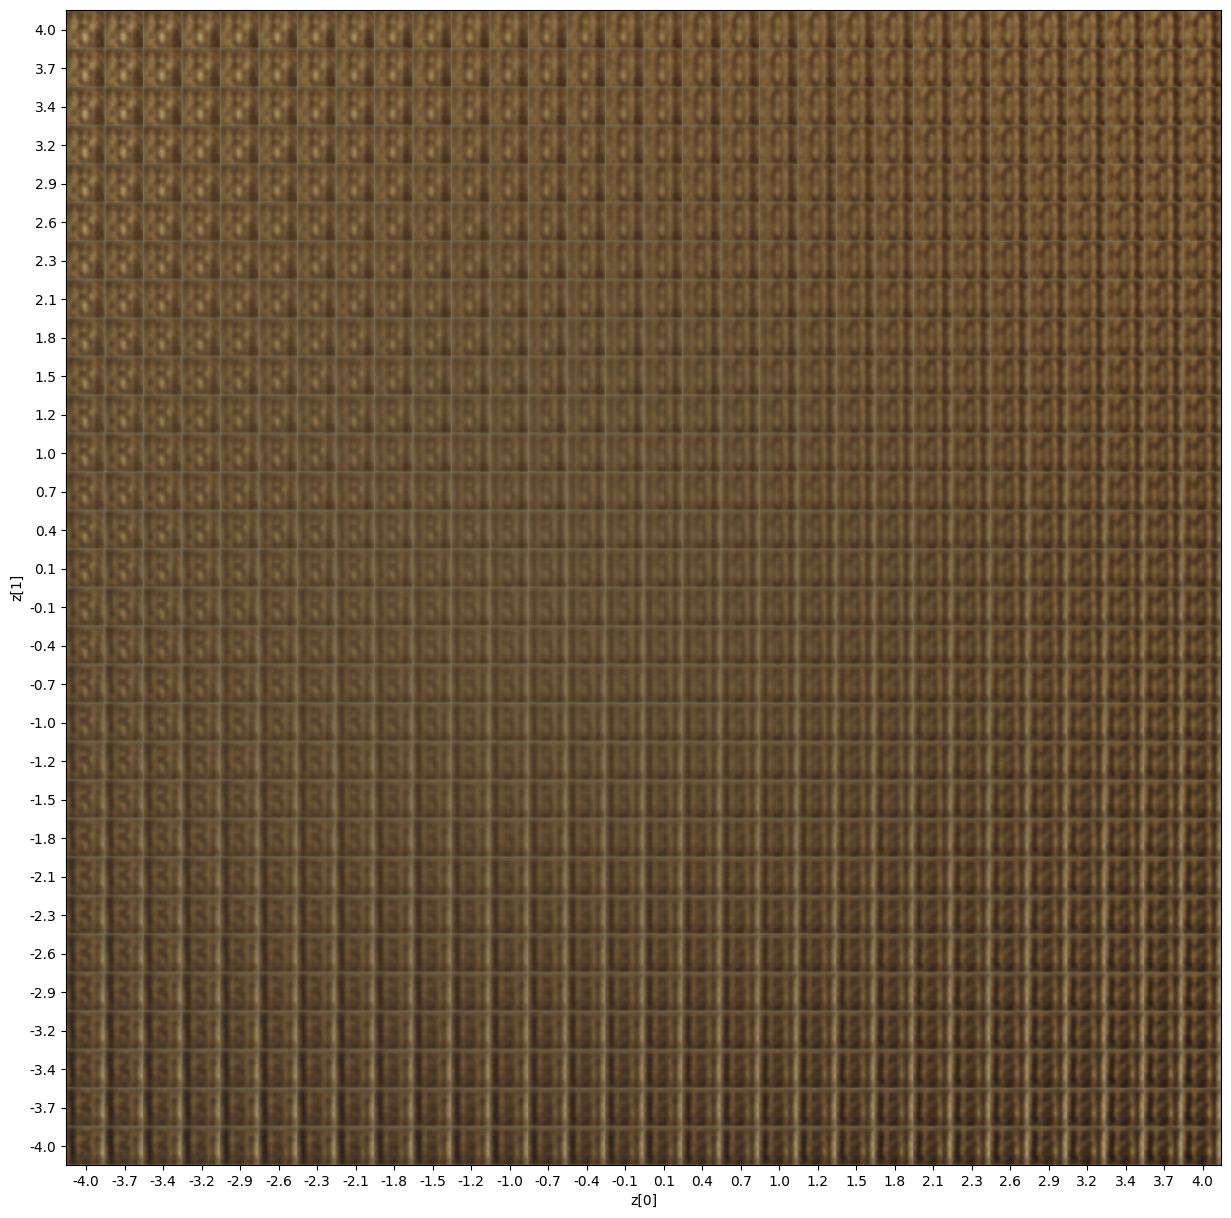

In [10]:
def plot_latent_space(ae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 32  # Changed digit_size to 256
    scale = 4.0
    figure = np.zeros((digit_size * n, digit_size * n, 3)) # Added an extra dimension for the 3 color channels
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            z_sample = np.pad(z_sample, ((0, 0), (0, ae.encoder.output_shape[1] - 2)), 'constant')
            x_decoded = ae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size, 3) # Reshape to include color channels
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure) # Removed cmap="Greys_r" as it's for grayscale images
    plt.show()


plot_latent_space(ae)

In [11]:
dataset

{Split('train'): <_PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 Split('test'): <_PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'extra': <_PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

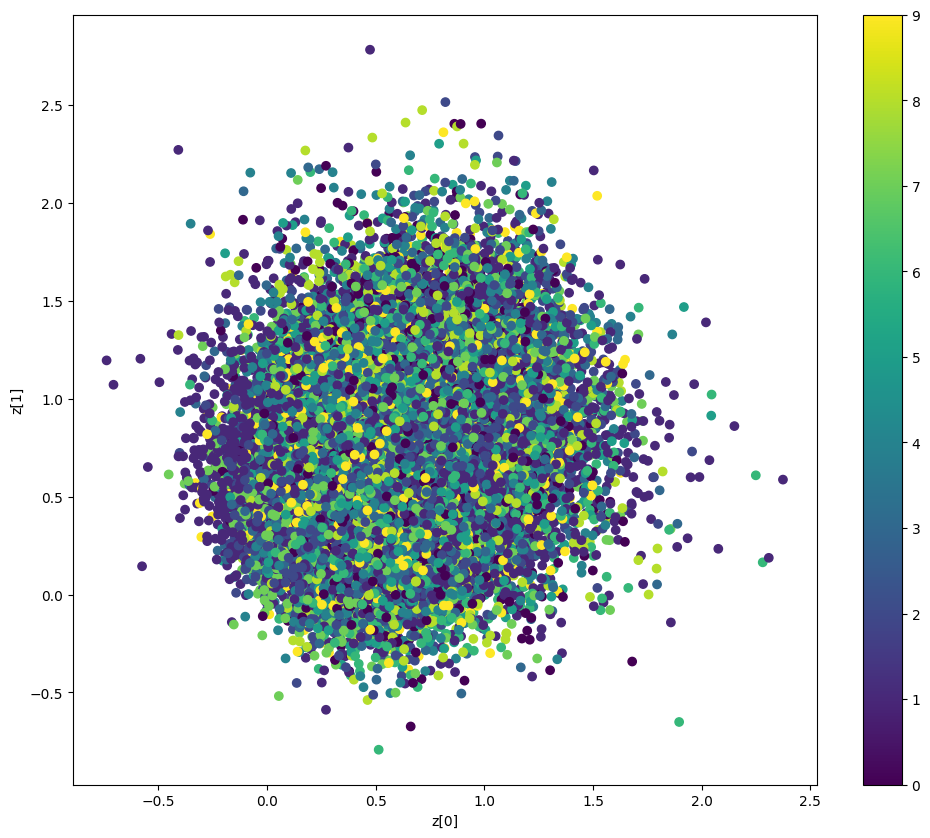

In [12]:
def plot_label_clusters(ae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean = ae.encoder.predict(data, verbose=0)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


x_train = dataset['train'].map(lambda image, label: image)
x_train = np.array([image.numpy() for image in x_train])
y_train = dataset['train'].map(lambda image, label: label)
y_train = np.array([label.numpy() for label in y_train])
x_train = x_train.astype("float32") / 255

plot_label_clusters(ae, x_train, y_train)


In [13]:
image_dataset

<_MapDataset element_spec=TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None)>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


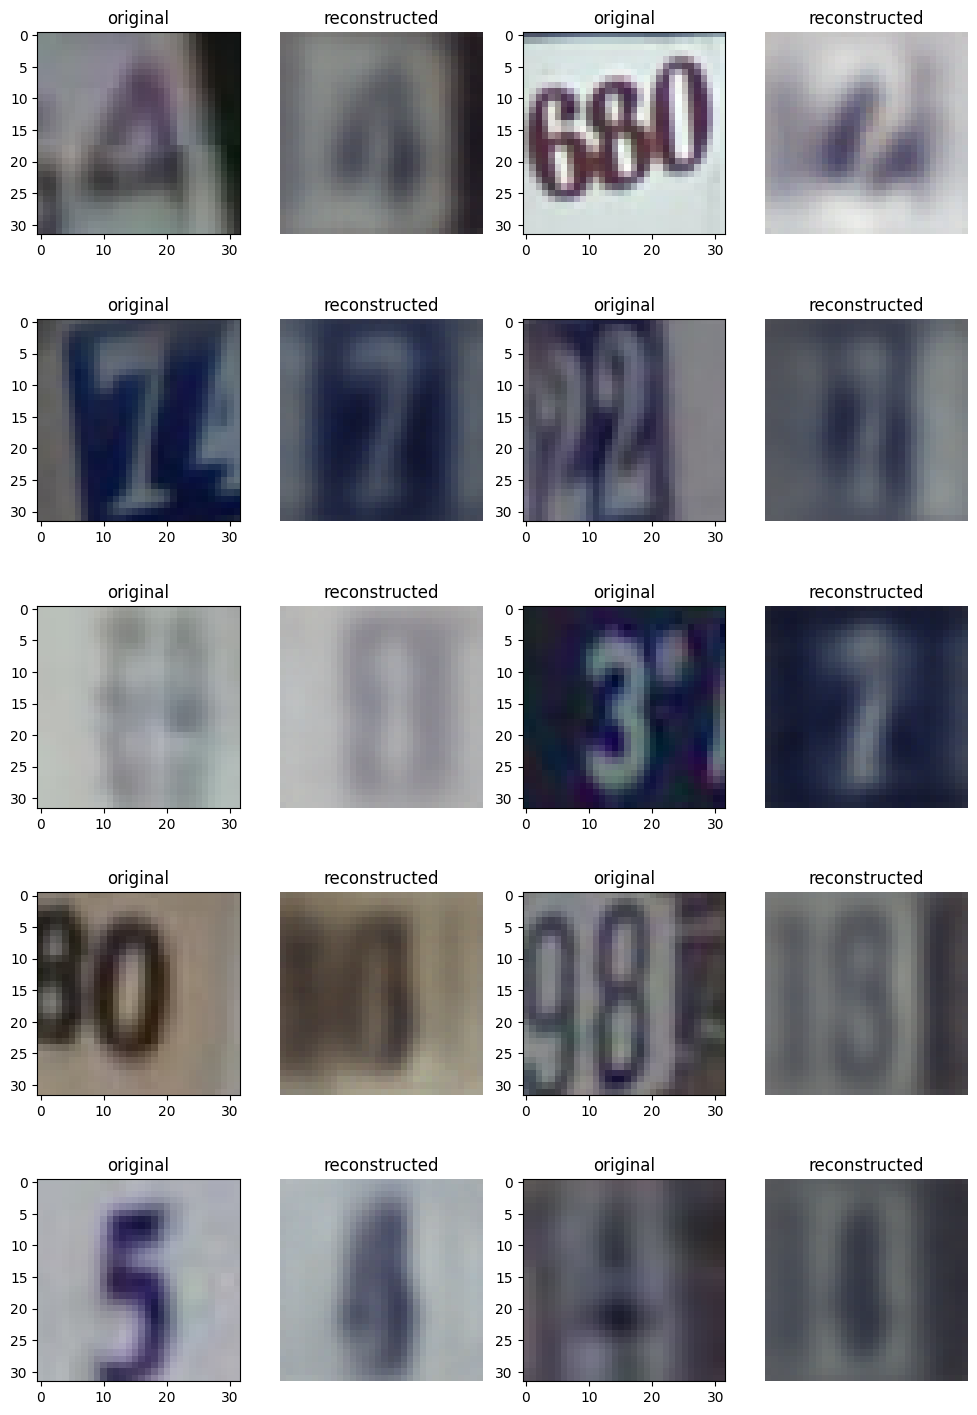

In [14]:
plt.figure(figsize=(12, 18))
image_dataset = dataset['train'].map(lambda image, label: image)

xs = image_dataset.batch(10)

for image_batch in xs.take(1):
  image_batch=image_batch/255
  ae_images = ae.predict(image_batch)
  for i in range(10):
    ax = plt.subplot(5, 4, (i * 2) + 1)
    plt.imshow(image_batch[i])
    plt.title('original')

    ax = plt.subplot(5, 4, (i * 2) + 2)
    plt.imshow(ae_images[i])
    plt.title('reconstructed')
    plt.axis("off")